# Study of the stability of several G&CNETs at the same time

In this notebook we define a dictionary with the filenames of several trained deep networks and we perform the stability analysis on all of them



| Packages needed    | 
|----------|
| scipy  | 
| numpy  | 
| matplotlib  | 
| pyaudi  |
| pygmo  |
| progressbar  |
| control  |


Can all be installed via pip  or conda package managers (tested in python 3.7)

In [1]:
%matplotlib inline

import pygmo as pg
from pyquad import Controller, rkf45, rkf45_gduals
import numpy as np
from math import sin, cos, sqrt, tanh
import progressbar

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

g0 = 9.81 # m/s2
m = 0.38905 # kg
T_max = 9.1 # N
theta_max = 35 # rad/sec



### 1 - Find the exact equilibrium point
We shift the reference system so that all neural controllers (GECNETs) will have the origin as equilibrum point. This corresponds to the quad hovering. We thus need to find such equilibrium point for all GECNETs 


In [2]:
# This pygmo problem is solved by the equilibrium point of the system
class my_prob:
    def __init__(self, path):
        self.Controller = Controller(path)
    def fitness(self, x):
        return [np.linalg.norm(self.Controller.compute_control(x) - np.array([g0*m, 0]))]
    def get_bounds(self):
        return ([-1,0,-1,0,0],[1,0,1,0,0])

In [3]:
# Here we create a dictionary that we will populate for each network with the stability margins
# [path, bias, error in equilibrium, controller, damp, freq, timedelay]
data = dict() 
data["N_01_0050"] = ["data/softplus/power_bebop_drag_h01_n0050_softplus.pkl", [], False, False,0.,0.,0.]
data["N_02_0050"] = ["data/softplus/power_bebop_drag_h02_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_03_0050"] = ["data/softplus/power_bebop_drag_h03_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_04_0050"] = ["data/softplus/power_bebop_drag_h04_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_05_0050"] = ["data/softplus/power_bebop_drag_h05_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_06_0050"] = ["data/softplus/power_bebop_drag_h06_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_07_0050"] = ["data/softplus/power_bebop_drag_h07_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_08_0050"] = ["data/softplus/power_bebop_drag_h08_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_09_0050"] = ["data/softplus/power_bebop_drag_h09_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_01_0100"] = ["data/softplus/power_bebop_drag_h01_n0100_softplus.pkl", [], False, False,0.,0.,0.]
data["N_02_0100"] = ["data/softplus/power_bebop_drag_h02_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_03_0100"] = ["data/softplus/power_bebop_drag_h03_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_04_0100"] = ["data/softplus/power_bebop_drag_h04_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_05_0100"] = ["data/softplus/power_bebop_drag_h05_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_06_0100"] = ["data/softplus/power_bebop_drag_h06_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_07_0100"] = ["data/softplus/power_bebop_drag_h07_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_08_0100"] = ["data/softplus/power_bebop_drag_h08_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_09_0100"] = ["data/softplus/power_bebop_drag_h09_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_01_0200"] = ["data/softplus/power_bebop_drag_h01_n0200_softplus.pkl", [], False, False,0.,0.,0.]
data["N_02_0200"] = ["data/softplus/power_bebop_drag_h02_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_03_0200"] = ["data/softplus/power_bebop_drag_h03_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_04_0200"] = ["data/softplus/power_bebop_drag_h04_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_05_0200"] = ["data/softplus/power_bebop_drag_h05_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_06_0200"] = ["data/softplus/power_bebop_drag_h06_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_07_0200"] = ["data/softplus/power_bebop_drag_h07_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_08_0200"] = ["data/softplus/power_bebop_drag_h08_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_09_0200"] = ["data/softplus/power_bebop_drag_h09_n0200_softplus.pkl", [], False,False,0.,0.,0.]

In [4]:
for N in progressbar.progressbar(data):
    udp = my_prob(data[N][0])
    prob = pg.problem(udp)
    algo = pg.algorithm(pg.de(gen=300, xtol=1e-14, ftol=1e-14))
    algo.set_verbosity(1)
    pop = pg.population(prob,19)
    pop.push_back([0,0,0,0,0])
    pop = algo.evolve(pop)
    data[N][1] = pop.champion_x
    err = np.linalg.norm(udp.Controller.compute_control(pop.champion_x) - np.array([3.81658050, 0]))
    data[N][2] = err

 92% (25 of 27) |######################  | Elapsed Time: 0:01:50 ETA:   0:00:25/usr/lib/python3.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
100% (27 of 27) |########################| Elapsed Time: 0:02:16 Time:  0:02:16


### 2 - Redefine the Controller so that the origin is the equilibrium point

In [5]:
class UnbiasedController(Controller):
    def __init__(self, path_to_pickle, bias):
        super(UnbiasedController, self).__init__(path_to_pickle)
        self.bias = np.array(bias)
    def compute_control(self, state):
        return super(UnbiasedController, self).compute_control(state + self.bias)

In [6]:
for N in progressbar.progressbar(data):
    data[N][3] = UnbiasedController(data[N][0], data[N][1])


100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [7]:
for N in progressbar.progressbar(data):
    a = data[N][3].compute_control([0,0,0,0,0])
    # To check the hovering equilibrium we print down the neurocontroller output at the found equilibrium
    print(N, "->", "u1 = ", a[0] / m, ", u2 = ", a[1])

100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


N_01_0050 -> u1 =  9.81 , u2 =  6.098203539361968e-15
N_02_0050 -> u1 =  9.810000000000032 , u2 =  -1.6227253915590545e-14
N_03_0050 -> u1 =  9.810000000000013 , u2 =  -5.52964792011057e-15
N_04_0050 -> u1 =  9.810000000000151 , u2 =  2.865633078052987e-14
N_05_0050 -> u1 =  9.810000000000032 , u2 =  -1.3437601725785342e-15
N_06_0050 -> u1 =  9.810000000019715 , u2 =  4.9437600280893834e-12
N_07_0050 -> u1 =  9.809999999999938 , u2 =  3.423758672405075e-14
N_08_0050 -> u1 =  9.810000000000018 , u2 =  4.702835343373124e-15
N_09_0050 -> u1 =  9.809999999999976 , u2 =  -2.9715813143482706e-15
N_01_0100 -> u1 =  9.809999999999995 , u2 =  -6.459676543668635e-16
N_02_0100 -> u1 =  9.809999999999963 , u2 =  -1.808774484357567e-14
N_03_0100 -> u1 =  9.81000000000003 , u2 =  1.609823385706477e-14
N_04_0100 -> u1 =  9.809999999999997 , u2 =  -5.994770652106851e-15
N_05_0100 -> u1 =  9.810000000000015 , u2 =  6.098203539361968e-15
N_06_0100 -> u1 =  9.810000000000027 , u2 =  -9.948422294292492e-1

### 3 - Simulate the dynamics

In [8]:
# This is a simple Runga Kutta fourth order numerical integrator with fixed step.
# It is programmed to work both with floats and gduals. It infers the type from the initial conditions.
# For creating plots and movies is ok, to do the Taylor map computations the rk45 (adaptive step) should be used.
def rk4(f, t0, y0, tf, N):
    h = (tf - t0) / N
    t = np.arange(t0,tf,h)
    y = np.array([[y0[0]] * np.size(y0)] * N)
    y[0] = y0
    for n in progressbar.progressbar(range(N - 1)):
        xi1 = y[n]
        f1 = f(t[n], xi1)
        xi2 = y[n] + (h/2.)*f1
        f2 = f(t[n+1], xi2)
        xi3 = y[n] + (h/2.)*f2
        f3 = f(t[n+1], xi3)
        xi4 = y[n] + h*f3
        f4 = f(t[n+1], xi4)
        y[n+1] = y[n] + (h/6.)*(f1 + 2*f2 + 2*f3 + f4)
    return y


    

In [9]:
# Our quad dynamics
def rhs(t, x, uc):
    u = uc.compute_control(x)
    return np.array([
        x[1],
         -0.5*x[1] + (u[0])/m * sin(x[4]),
        x[3],
        -0.5 *x[3] - g0 + (u[0])/m * cos(x[4]),
         u[1],
    ])

#### Trajectory plot (comparing two networks)

In [10]:
# Initial condition for the plots (x,vx,z,vz,theta)
IC = np.array([ 4. ,2., 7.,1.,1.4])
# Which one?
key1 = "N_01_0050"
key2 = "N_05_0200"

tf = 5
N = 100

res1 = rk4(lambda t,x: rhs(t,x,data[key1][3]), 0, IC, tf, N)
res2 = rk4(lambda t,x: rhs(t,x,data[key2][3]), 0, IC, tf, N)


x1 = res1[:,0]
vx1 = res1[:,1]
z1 = res1[:,2]
vz1 = res1[:,3]
theta1 = res1[:,4]
x2 = res2[:,0]
vx2 = res2[:,1]
z2 = res2[:,2]
vz2 = res2[:,3]
theta2 = res2[:,4]
t = np.arange(0, tf, tf/ N)

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


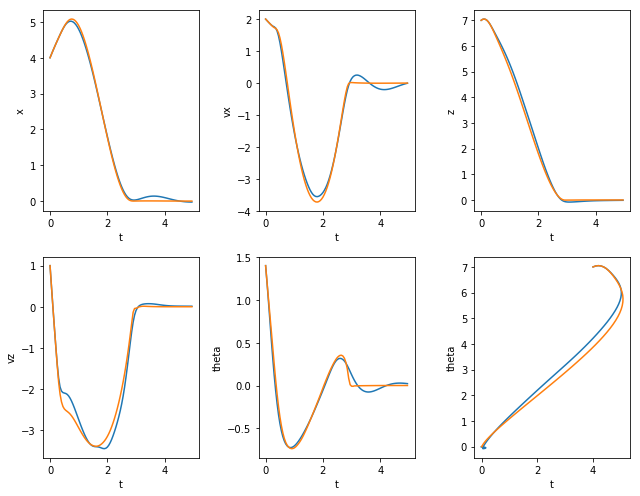

In [11]:
# And we plot (statically) the resulting trajectories
plt.figure(figsize=(9,7))
plt.subplot(231)
plt.plot(t, x1)
plt.plot(t, x2)
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(232)
plt.plot(t, vx1)
plt.plot(t, vx2)
plt.xlabel("t")
plt.ylabel("vx")
plt.subplot(233)
plt.plot(t, z1)
plt.plot(t, z2)
plt.xlabel("t")
plt.ylabel("z")
plt.subplot(234)
plt.plot(t, vz1)
plt.plot(t, vz2)
plt.xlabel("t")
plt.ylabel("vz")
plt.subplot(235)
plt.xlabel("t")
plt.ylabel("theta")
plt.plot(t, theta1)
plt.plot(t, theta2)
plt.subplot(236)
plt.xlabel("t")
plt.ylabel("theta")
plt.plot(x1, z1)
plt.plot(x2, z2)
plt.tight_layout()

### 4 - Analyze the System Stability (linear)

The system linear stabilty around the equilibrium point (origin) is studied. 

Write the overall system as:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x)
$$

introduce the variable $\mathbf x = \mathbf x_e + \delta \mathbf x$. Then:

$$
\dot {\delta \mathbf x} = \nabla \mathbf f \cdot \delta \mathbf x
$$

The resulting linear system has an analytical solution readily found by:

$$
\delta \mathbf x = e^{\mathbf A t} \delta \mathbf x_0
$$

Using the eigen decomposition of the matrix $\mathbf A$ we may write $\mathbf A\mathbf V = \mathbf V\mathbf \Lambda$. Where we have introduced the right eigenvector matrix $\mathbf V = [\mathbf v_1, \mathbf v_2, ...]$ and the eigenvalue matrix $\mathbf \Lambda$. 

Eventually the system dynamics is thus expressed as:

$$
\delta \mathbf x = \mathbf V^{-1} e^{\mathbf \Lambda t} \mathbf V 
$$

and will thus be some linear combination of terms in the form $e^{-\lambda_i t}$. The real part of the eigenvalues is then determining the asymptotic behavior of the system (needs to be negative to give asymptotic stability and its magnitude regulates the system damping time), while the imaginary part $\omega_i$ determines the oscillating behaviour introducing a frequency $f = \frac {\omega}{2\pi}$.

In [12]:
from pyaudi import gdual_double as gdual
from pyaudi import sin, cos, sqrt, tanh

# Equilibrium point
x_e = [gdual(0., name, 1) for name in ["x","vx","z","vz","th"]]

In [13]:
for N in progressbar.progressbar(data):
    # We compute the gradient of the rhs
    lin_dyn = rhs(0, x_e, data[N][3])
    ss = ["dx", "dvx", "dz", "dvz", "dth"]
    _ = [a.extend_symbol_set(ss) for a in lin_dyn]
    A = np.eye(5)
    for i in range(5):
        for  j in range(5):
            A[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})
            lambdas, eigv = np.linalg.eig(A)
    decay = []
    freq = []
    for i, lam in enumerate(lambdas):
        alpha = lam.real
        beta = lam.imag
        #print("Mode ", i+1, ": ", end='', flush=True)
        if alpha < 0:
            #print("STABLE!", end = '', flush=True)
            if beta!=0:
                #print(" - complex", end='')
                #print("\n\t decay time (10%): ", np.log(0.1)/alpha, "s")
                #print("\t period: ", 2*np.pi/beta, "s", flush=True)
                decay.append(np.log(0.1)/alpha)
                freq.append(2*np.pi/beta)
            else:
                #print(" - real", end='')
                #print("\n\t decay time (10%): ", np.log(0.1)/alpha, "s", flush=True)
                decay.append(np.log(0.1)/alpha)
                freq.append(0)
        else:
            print("UNSTABLE!", flush=True)
    data[N][4] = max(decay)
    data[N][5] = max(freq)


 85% (23 of 27) |####################    | Elapsed Time: 0:00:08 ETA:   0:00:05

UNSTABLE!


100% (27 of 27) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


### 5 - Analyze the System Stability to time delays (linear)

The system linear stabilty around the equilibrium point (origin) is studied when a time delay $\tau$ is introduced in the control input.

We write the overall system as:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x, \mathbf x^\tau)
$$

and, again considering small displacements around the stable equilibrium point at the origin, we have the representation:

$$
\dot {\delta \mathbf x} = \mathbf A \delta \mathbf x + \mathbf B \delta \mathbf x^\tau 
$$

where we have used the notation $\mathbf x = \mathbf x(t)$, $\mathbf x^\tau = \mathbf x(t-\tau)$.

This linear system with time delay has the general solution:

$$
\delta \mathbf x(t) = e^{\Phi t}\mathbf x_0
$$

where the matrix $\mathbf \Phi$ eigenvalues are obtained from the time-delayed characteristic equation:

$$
\left|\mathbf A + \mathbf Be^{-\lambda \tau} - \lambda\mathbf I\right| = 0
$$

note that for $\tau =0$ (no delay) we recover the stability study of the undelayed system.


In [14]:
# We write the dynamics as a function of both the signal and the delayed signal
def rhs_delay(t, x, xtau, uc):
    u = uc.compute_control(xtau)
    return np.array([
        x[1],
        - 0.5 * x[1] + u[0]/m * sin(x[4]),
        x[3],
        -0.5 * x[3] - g0 + u[0]/m * cos(x[4]),
         u[1],
    ])
# This must be zero if x[1] is the crossing of the imaginary axis and x[0] the time delay when it happens.
def stability_margin(x, A, B):
    # x is [tau, imag], real assumed to be zero
    lam = 1j*x[1]
    det = np.linalg.det(B*np.exp(-lam*x[0])+A-lam*np.eye(5))
    return [det.real, det.imag]

# Finding the delay with pade approximant as initial guess

In [15]:
# find the maximum allowable delay
import numpy as np
import scipy.linalg as scl
import matplotlib.pyplot as plt
import control

def find_timedelay_pade(A, B, norder = 5, ntau = 100):
    tau_vec = np.linspace(0.0001, 0.15, ntau)
    del_crit = 0.
    imag_crit = 0.
    for ik in range(0,ntau):
        # calculate the delay
        nump, denp = control.pade(tau_vec[ik], norder)
        Ap, Bp, Cp, Dp = control.ssdata(control.tf2ss(nump, denp))
        
        Ap = scl.block_diag(*((Ap,)*nstate))
        Bp = scl.block_diag(*((Bp,)*nstate))
        Cp = scl.block_diag(*((Cp,)*nstate))
        Dp = scl.block_diag(*((Dp,)*nstate))

        # interconnect the system
        Ad11 = A+np.matmul(B,Dp)
        Ad12 = np.matmul(B,Cp)
        Ad1 = np.concatenate((Ad11,Ad12), axis=1)
        Ad2 = np.concatenate((Bp,Ap), axis=1)
        Ad = np.concatenate((Ad1,Ad2), axis=0)

        eig_tmp = np.linalg.eigvals(Ad)

        if np.any(np.real(eig_tmp)>0):
            del_crit = 0.5*(tau_vec[ik] + tau_vec[ik-1])
            imag_crit = np.imag(eig_tmp)[np.real(eig_tmp)>0]
            break

    return del_crit, abs(imag_crit[0])

# do the calculations
norder = 5
ntau = 100
nstate = A.shape[0]
for N in data:
    # We compute the gradient of rhs_delay w.r.t. x and thus A (we call it Ad to retain A in the notebook)
    xtau_e = [gdual(0., name, 1) for name in ["xt","vxt","zt","vzt","tht"]]
    lin_dyn = rhs_delay(0., x_e, xtau_e, data[N][3])
    ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
    _ = [a.extend_symbol_set(ss) for a in lin_dyn]
    Ad = np.eye(5)
    for i in range(5):
        for  j in range(5):
            if lin_dyn[i].order == 0: # its a constant
                Ad[i,j] = 0
            else:
                Ad[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})
    # We compute the gradient of rhs_delay w.r.t. x_tau and thus B (we call it Bu to retain B in the notebook)
    #lin_dyn = rhs_delay(0., x_e, xtau_e)
    #ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
    #_ = [a.extend_symbol_set(ss) for a in lin_dyn]
    Bu = np.eye(5)
    for i in range(5):
        for  j in range(5):
            if lin_dyn[i].order == 0: # its a constant
                Bu[i,j] = 0
            else:
                Bu[i,j] = lin_dyn[i].get_derivative({ss[j+5] : 1})
    # Initial guess from pade
    tau, imags = find_timedelay_pade(Ad, Bu, norder = norder, ntau = ntau)
    print('Pade critical delay:', tau, ' Critical crossing:', imags)
    from scipy.optimize import root
    # Refine the initial guess
    sol = root(stability_margin, [tau, imags], (Ad, Bu), tol=1e-10)
    print('Corr critical delay:', sol.x[0], ' Critical crossing:', sol.x[1], "\n")
    data[N][6] = sol.x[0]


Pade critical delay: 0.13712979797979796  Critical crossing: 11.114850181119822
Corr critical delay: 0.1372621316689068  Critical crossing: 11.150557881072434 

Pade critical delay: 0.03416818181818182  Critical crossing: 44.45906088250435
Corr critical delay: 0.03402207468381343  Critical crossing: 45.29606219711328 

Pade critical delay: 0.02356919191919192  Critical crossing: 64.9070148487418
Corr critical delay: 0.023293897406638606  Critical crossing: 66.95299130353536 

Pade critical delay: 0.026597474747474748  Critical crossing: 55.879450733506815
Corr critical delay: 0.02625115988513536  Critical crossing: 57.54094060471294 

Pade critical delay: 0.03719646464646465  Critical crossing: 39.44533054498621
Corr critical delay: 0.03698958466019307  Critical crossing: 40.16855657205634 

Pade critical delay: 0.03871060606060606  Critical crossing: 37.02531780899353
Corr critical delay: 0.03857632718474258  Critical crossing: 37.62341665649075 

Pade critical delay: 0.05536616161616

In [16]:
# [path, bias, error in equilibrium, controller, damp, freq, timedelay]
for N in data:
    print("$\mathcal N^{{{}}}_{{{}}}$ & {:0.2f}s & {:0.2f}s & {:0.3f}s \\\\".format(int(N[-4:]), int(N[2:4]), data[N][4], data[N][5], data[N][6]))

$\mathcal N^{50}_{1}$ & 2.27s & 2.41s & 0.137s \\
$\mathcal N^{50}_{2}$ & 1.66s & 0.00s & 0.034s \\
$\mathcal N^{50}_{3}$ & 1.73s & 2.63s & 0.023s \\
$\mathcal N^{50}_{4}$ & 1.26s & 2.52s & 0.026s \\
$\mathcal N^{50}_{5}$ & 1.19s & 3.32s & 0.037s \\
$\mathcal N^{50}_{6}$ & 0.89s & 2.07s & 0.039s \\
$\mathcal N^{50}_{7}$ & 0.59s & 2.00s & 0.056s \\
$\mathcal N^{50}_{8}$ & 0.71s & 8.34s & 0.069s \\
$\mathcal N^{50}_{9}$ & 0.78s & 2.68s & 0.091s \\
$\mathcal N^{100}_{1}$ & 1.97s & 2.48s & 0.140s \\
$\mathcal N^{100}_{2}$ & 2.09s & 3.80s & 0.029s \\
$\mathcal N^{100}_{3}$ & 1.80s & 3.59s & 0.023s \\
$\mathcal N^{100}_{4}$ & 2.54s & 0.00s & 0.032s \\
$\mathcal N^{100}_{5}$ & 1.52s & 0.00s & 0.037s \\
$\mathcal N^{100}_{6}$ & 1.40s & 1.19s & 0.091s \\
$\mathcal N^{100}_{7}$ & 1.70s & 1.06s & 0.071s \\
$\mathcal N^{100}_{8}$ & 1.25s & 2.18s & 0.059s \\
$\mathcal N^{100}_{9}$ & 2.13s & 0.56s & 0.047s \\
$\mathcal N^{200}_{1}$ & 1.64s & 2.56s & 0.134s \\
$\mathcal N^{200}_{2}$ & 1.94s & 3.17s &